# 1. Environment setup 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install syllabipy

     |████████████████████████████████| 3.1 MB 9.6 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 54.2 MB/s 
     |████████████████████████████████| 3.3 MB 23.5 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for syllabipy: filename=syllabipy-0.2-py3-none-any.whl size=5813 sha256=8b27b4c54e9e2bd77ecbf53985c1885043afc2ad62c6896fb0c625f9a74e1087
  Stored in directory: /root/.cache/pip/wheels/5a/43/1a/9078e0df36fa76df8c584c20b0eeb924ad8686d240b1a9646a
Successfully built syllabipy


In [3]:
import numpy as np
import pandas as pd 
import random
import time
import datetime
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
from syllabipy.sonoripy import SonoriPy
from transformers import BertTokenizer
from tqdm import tqdm

# 2. Load data

In [5]:
poem_df = pd.read_csv("/content/limricks_end_with_[SEP]_sep_with_-.csv")
poem_df = poem_df.fillna("")

# 3. Process Text and Create Dataset

In [6]:
batch_size = 16
epochs = 20
max_len = 60
device = torch.device('cuda')
learning_rate = 1e-4
eps = 1e-8
syl_num = 5
word_embed_dim = 256
syl_embed_dim = 64
total_embed_dim = word_embed_dim + syl_embed_dim * syl_num

In [7]:
word_tokenizer = BertTokenizer.from_pretrained("/content/tokenizer[SEP]--vocab.txt")
syl_tokenizer = BertTokenizer.from_pretrained("/content/fre_1_syllables-vocab.txt")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1645: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
print("Length of word_tokenizer : {}".format(len(word_tokenizer)))
print("Length of syl_tokenizer : {}". format(len(syl_tokenizer)))

Length of word_tokenizer : 30003
Length of syl_tokenizer : 22383


In [9]:
class PoemDataset(Dataset):
    
    def __init__(self, data, tokenizer, max_length=max_len):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        encodings_dict = self.tokenizer(self.data[idx],
                                        truncation=True,
                                        max_length=self.max_length,
                                        padding='max_length'
                                        )
        input_ids = encodings_dict['input_ids']
        if None in input_ids:
          input_ids = torch.zeros(self.max_length)
          attention_mask = torch.zeros(self.max_length)
        else:
          input_ids = torch.tensor(encodings_dict['input_ids'])
          attention_mask = torch.tensor(encodings_dict['attention_mask'])
        input_ids = input_ids.type(torch.LongTensor)
        return input_ids, attention_mask        

In [10]:
poem_dataset = PoemDataset(poem_df.iloc[:, 0].values, word_tokenizer, max_len)

# 4. Train/Validation

# 5. Instantiate DataLoaders and Define Model Creation Function

In [11]:
poem_dataloader = DataLoader(poem_dataset, batch_size=batch_size, shuffle=True)

In [23]:
max_poem_length = max([len(word_tokenizer.encode(poem)) for poem in poem_df.iloc[:, 0].values])

In [25]:
a = [len(word_tokenizer.encode(poem)) for poem in poem_df.iloc[:, 0].values]

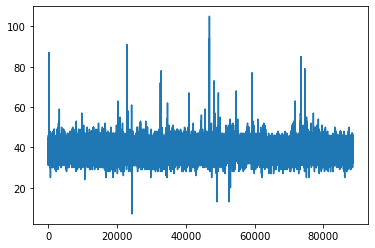

In [29]:
import matplotlib.pyplot as plt
plt.plot(a)

# 6. Create Poem Model

In [12]:
configuration = GPT2Config(vocab_size=len(word_tokenizer), n_positions=max_len, n_embd=total_embed_dim)
model = GPT2LMHeadModel(config=configuration)
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30003, 576)
    (wpe): Embedding(60, 576)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
  

## 6.1 Sylliabification Embedding

In [13]:
class translater():
  def __init__(self, word_tokenizer, syl_tokenizer):
    self.word_tokenizer = word_tokenizer
    self.syl_tokenizer = syl_tokenizer

  def word_to_syl(self, x):
    
    """ 
    Convert word(tokenizer) to syllable(tokenizer) list  
    args:
      x : interger tokenzier 
    return:
      syl_list : list of syllable tokenizer
    """
    input_id = torch.tensor([x])
    word = word_tokenizer.decode(input_id)
    syllable_list = SonoriPy(word)  # a list of syllables
    result = [self.syl_tokenizer.encode(i)[1] for i in syllable_list]
    result = [i for i in result if i]
    return result

In [14]:
class syl_embedding(nn.Module):
  def __init__(self, vocab_size, syl_size, syl_embed_len, word_embed_dim, word_to_syl, syl_embed_dim):
    super(syl_embedding, self).__init__()
    self.vocab_size = vocab_size
    self.word_embed_dim = word_embed_dim
    self.syl_embed_dim = syl_embed_dim
    self.syl_embed_len = syl_embed_len
    self.word_embedding = nn.Embedding(vocab_size, word_embed_dim)
    self.syl_embedding  = nn.Embedding(syl_size, syl_embed_dim)
    self.word_to_syl = word_to_syl
  def forward(self, x):
    word_embedding = self.word_embedding(x)
    syl_embedding = torch.zeros(word_embedding.shape[0], word_embedding.shape[1], self.syl_embed_len*self.syl_embed_dim)
    # print(syl_embedding.shape)

    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
        syls = self.word_to_syl(x[i, j])
        syl_len = min(len(syls), self.syl_embed_len)

        # if it is special token
        # if(x[i, j] >= 30000 or x[i, j] <= 3):
        #   syl_embedding[i, j] = torch.zeros(self.syl_embed_dim * self.syl_embed_len)
        #   continue
        # not a special token 
        for k in range(syl_len):
          syl = syls[k]
          syl = torch.tensor(syl).to(device)
          syl_embedding[i, j, (self.syl_embed_len-syl_len+k) * self.syl_embed_dim : (self.syl_embed_len-syl_len+k+1)*self.syl_embed_dim] = self.syl_embedding(syl)

    syl_embedding = syl_embedding.to(device)
    final_embed = torch.cat((word_embedding, syl_embedding), dim=2)
    return final_embed 

## 6.2 Modify gpt2 architecture

In [15]:
trans = translater(word_tokenizer, syl_tokenizer)
syl_embed = syl_embedding(len(word_tokenizer), len(syl_tokenizer), 5, word_embed_dim=word_embed_dim, word_to_syl = trans.word_to_syl, syl_embed_dim=syl_embed_dim)
model.transformer.wte = syl_embed
# print(model)

# 6.3 Train

In [ ]:
# model.cuda()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)
total_steps = len(poem_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=50,
                                            num_training_steps=total_steps)
start_time = time.time()
model = model.to(device)
for epoch_i in range(epochs):

    print(f'Epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for batch in tqdm(poem_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask=b_masks,
                        token_type_ids=None)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       
    training_time = (time.time() - t0)
    torch.save(model.state_dict(), '/content/drive/MyDrive/11785/project/modelll.pth')
    print(f'Average Training Loss: {avg_train_loss}. Epoch Training Time: {training_time}. Learning rate: {optimizer.param_groups[0]["lr"]}')

Epoch 1 of 20


 13%|█▎        | 739/5532 [08:53<57:33,  1.39it/s]

In [16]:
state_dict = torch.load('/content/drive/MyDrive/11785/project/modelll.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:
optimizer.param_groups[0]["lr"]

NameError: ignored

# 7. Generate Poem Stanzas

RuntimeError: ignored

In [22]:
prompt = "[CLS]"
generated = torch.tensor(word_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
model.cuda()
model.eval()
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=30, 
                                max_length=60,
                                top_p=0.92, 
                                num_return_sequences=3)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, word_tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: thats a small bird whos a whiz - of his life and his body is odd - as a bird you have heard - the name in the main kind - and thats true it can make you seem grand


1: ##s a new dress on this boat is the main - and its name is now used as a joke - its a way to get laid - to define and get laid - of this word for a treat - when it comes and youd need to a lot more to a week


2: and quite an old way out of strife - the name that he used in a wife of the strife - was the best that his brother - with the guy was the story - so she left her in his life as a fool




In [ ]:
SonoriPy('rigid')

['ri', 'gid']

# Test

In [ ]:
word_tokenizer.decode(torch.tensor([1]))

'-'

In [ ]:
trans.word_to_syl(1)

[]

In [ ]:
# syl_embed = syl_embed.to(device)
model = model.to(device)
for batch in tqdm(poem_dataloader):
  b_input_ids = batch
  

  0%|          | 0/2766 [00:00<?, ?it/s]

torch.Size([32, 120, 320])


  0%|          | 1/2766 [00:00<43:15,  1.07it/s]

torch.Size([32, 120, 320])


  0%|          | 2/2766 [00:01<44:24,  1.04it/s]

torch.Size([32, 120, 320])


  0%|          | 3/2766 [00:02<44:47,  1.03it/s]

torch.Size([32, 120, 320])


  0%|          | 4/2766 [00:03<44:26,  1.04it/s]

torch.Size([32, 120, 320])


  0%|          | 5/2766 [00:04<44:47,  1.03it/s]

torch.Size([32, 120, 320])


  0%|          | 6/2766 [00:05<44:38,  1.03it/s]

torch.Size([32, 120, 320])


  0%|          | 7/2766 [00:06<45:43,  1.01it/s]

torch.Size([32, 120, 320])


  0%|          | 8/2766 [00:07<45:02,  1.02it/s]

torch.Size([32, 120, 320])


  0%|          | 9/2766 [00:08<45:13,  1.02it/s]

torch.Size([32, 120, 320])


  0%|          | 10/2766 [00:09<45:07,  1.02it/s]

torch.Size([32, 120, 320])


  0%|          | 11/2766 [00:10<44:32,  1.03it/s]

torch.Size([32, 120, 320])


  0%|          | 12/2766 [00:11<44:25,  1.03it/s]

torch.Size([32, 120, 320])


  0%|          | 13/2766 [00:12<45:18,  1.01it/s]

torch.Size([32, 120, 320])


  1%|          | 14/2766 [00:13<45:38,  1.01it/s]

torch.Size([32, 120, 320])


  1%|          | 15/2766 [00:14<45:34,  1.01it/s]

torch.Size([32, 120, 320])


  1%|          | 16/2766 [00:15<45:08,  1.02it/s]


KeyboardInterrupt: ignored